In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import tensorflow_datasets as tfds

In [ ]:
tfds.disable_progress_bar()
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels




In [46]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image =  (image - 127.5) - 1

  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image , label

In [47]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
test

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
train_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)
base_model.trainable = False

(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer ,
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.3658 - loss: 0.9424


In [ ]:
# Now we can train it on our images
initial_epochs = 3
validation_steps=20
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 389s 656ms/step - accuracy: 0.9242 - loss: 0.1581 - val_accuracy: 0.9841 - val_loss: 0.0482
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 451s 673ms/step - accuracy: 0.9842 - loss: 0.0442 - val_accuracy: 0.9850 - val_loss: 0.0450
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 441s 671ms/step - accuracy: 0.9869 - loss: 0.0390 - val_accuracy: 0.9828 - val_loss: 0.0437
[0.9670607447624207, 0.9836646914482117, 0.9858677983283997]


In [ ]:
class_names = ['cat' , 'dog']
all_predictions=[]
for image_batch, label_batch in test_batches.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch).flatten()
    all_predictions.extend(predictions)

print('Predictions:\n', all_predictions)



Predictions:
 [-8.841193, 3.7154827, 5.511882, -8.819292, -7.451896, -12.476486, 6.5878835, -2.6821535, -9.78798, -9.633012, 5.824658, -14.040221, -9.068031, 8.4964075, -14.438111, -13.794787, -6.3959365, 6.238887, -8.564505, 10.321145, -10.174415, -10.596525, -10.63182, 9.4024, -12.327452, -7.5765157, 6.934233, 9.506955, -5.8932977, -7.743191, -10.477263, -10.337924, -7.798532, 10.599764, -7.9145927, -12.1200285, -9.095059, -10.628493, -9.792544, -13.734689, -12.475499, -10.555207, -13.818352, 4.4414043, -8.786091, 6.951369, -14.331657, -10.680537, 5.9147744, -11.016641, -11.604547, -13.753803, -11.95018, -11.327179, 8.5968485, -6.996068, -13.559446, -9.559755, 5.4144173, -12.565486, -14.774899, -7.4037437, -10.176167, -9.678721, -9.078933, 7.8273907, -10.364578, -13.884578, -6.339153, 6.519557, 3.5185082, -11.326363, -9.453691, 2.1783357, -9.927255, -1.9840926, 4.520894, -3.0238638, -12.338721, -4.7268577, 4.6941595, 2.1892543, -11.785411, 5.4702997, 3.9732594, -10.070691, -8.201777,

choose an image number between 0 and 1700500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
this is the picture that you have chosen


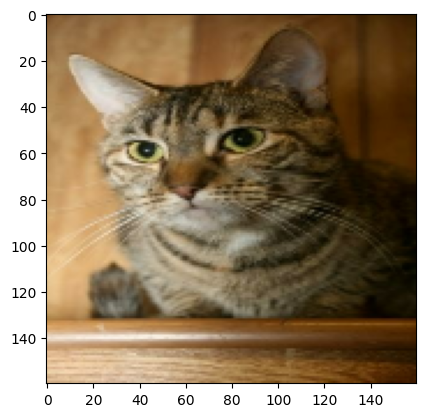

In [71]:
a=int(input('choose an image number between 0 and 1700'))

for image, label in raw_test.skip(a).take(1):
  image = tf.cast(image, tf.float32)
  image =  (image/255.0)
  image = tf.image.resize(image, (160, 160))
  image = tf.expand_dims(image, axis=0)
  pred_new=model.predict(image)
  plt.figure()
  plt.imshow(image[0])
  print('this is the picture that you have chosen')


In [72]:
b=all_predictions[a]
if b<0:
  pred='khat :D'
else:
  pred='doggo >:)'
print('This is a ....',pred)


This is a .... khat :D
